In [13]:
import os, cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, namedtuple
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [14]:
# 함수
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df["filename"]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    return imgs, df.iloc[:,1:]

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# 회전
def rotate_data(img_data, label_data, angle_list):
    df_concated = label_data.copy()
    imgs = []
    for i in angle_list:
        matrix = cv2.getRotationMatrix2D((img_data.shape[1]/2, img_data.shape[2]/2), i, 1)
        for j in tqdm(img_data):
            dst = cv2.warpAffine(j, matrix, j.shape[:2])
            imgs.append(dst)
        df_concated = pd.concat([df_concated, label_data])
    imgs = np.array(imgs, dtype='float32')
    return np.concatenate([img_data, imgs]), df_concated

In [15]:
seed_everything(42)

In [16]:
# 메타데이터 불러오기
df = pd.read_csv("./full_df.csv")
df = df.iloc[:,[-1, -3]]
df['labels'] = df['labels'].map(lambda x: x[2])
df["filename"] = df["filename"].map(lambda x : "./preprocessed_images/" + x).rename("path")

,filename,labels
0,./preprocessed_images/0_right.jpg,N
1,./preprocessed_images/1_right.jpg,N
2,./preprocessed_images/2_right.jpg,D
3,./preprocessed_images/4_right.jpg,D
4,./preprocessed_images/5_right.jpg,D
...,...,...
6387,./preprocessed_images/4686_left.jpg,D
6388,./preprocessed_images/4688_left.jpg,D
6389,./preprocessed_images/4689_left.jpg,D
6390,./preprocessed_images/4690_left.jpg,D


In [17]:
df_N = df.query('labels == "N"')
df_D = df.query('labels == "D"')
df_O = df.query('labels == "O"')
df_H = df.query('labels == "H"')
df_C = df.query('labels not in ["N","D","O","H"]')

((2873, 2),
 (1608, 2),
 (708, 2),
 (128, 2),
 C    293
 G    284
 A    266
 M    232
 Name: labels, dtype: int64)

In [18]:
N_imgs, df_N = create_datasets(df_N, 250, 250)
D_imgs, df_D = create_datasets(df_D, 250, 250)
O_imgs, df_O = create_datasets(df_O, 250, 250)
H_imgs, df_H = create_datasets(df_H, 250, 250)
C_imgs, df_C = create_datasets(df_C, 250, 250)

100%|█████████████████████████████████████████████████████████████████████████████| 1075/1075 [00:03<00:00, 346.86it/s]


In [19]:
df_C

,labels
11,M
14,M
16,M
20,C
34,A
...,...
4697,C
4698,C
4699,C
4700,C


In [21]:
################################################
#    데이터 회전
################################################
C_imgs, df_C = rotate_data(C_imgs, df_C, [-10, 10])
H_imgs, df_H = rotate_data(H_imgs, df_H, [-20, -10, 10, 20])

100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1372.67it/s]


In [23]:
D_imgs, df_D = np.concatenate([D_imgs, D_imgs[:,:,::-1,:]]), pd.concat([df_D, df_D])

In [24]:
##########################################################
# H_imgs[:,:,::-1,:] 데이터 좌우 반전

#np.dstack 데이터 이동(1픽셀)
##########################################################
H_imgs, df_H = np.concatenate([H_imgs, H_imgs[:,:,::-1,:], 
                               np.dstack([H_imgs[:,:,10:,:], np.zeros((640,250,10,3))]),
                               np.dstack([np.zeros((640,250,10,3)), H_imgs[:,:,:240,:]])
                              ]),\
               pd.concat([df_H, df_H, df_H, df_H])

In [25]:
C_imgs = np.concatenate([C_imgs, C_imgs[:,:,::-1,:], np.dstack([C_imgs[:,:,10:,:], np.zeros((3225,250,10,3))]),
                         np.dstack([np.zeros((3225,250,10,3)), C_imgs[:,:,:240,:]])])

df_C = pd.concat([df_C, df_C, df_C, df_C])

In [26]:
train_imgs = np.concatenate([N_imgs, D_imgs, O_imgs, H_imgs, C_imgs])
full_df = pd.concat([df_N, df_D, df_O, df_H, df_C])

C    3516
G    3408
D    3216
A    3192
N    2873
M    2784
H    2560
O     708
Name: labels, dtype: int64

In [28]:
df = pd.get_dummies(full_df, columns=["labels"])

In [20]:
del df_N, df_D, df_O, df_H, df_C
del N_imgs, D_imgs, O_imgs, H_imgs, C_imgs

In [30]:
train_imgs, test_imgs, train_df, test_df = train_test_split(train_imgs, df, test_size=0.2, random_state=42)

train_imgs, val_imgs, train_df, val_df = train_test_split(train_imgs, train_df, test_size=0.15, random_state=42)

# 학습

In [31]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
train_imgs = preprocess_input(train_imgs)
val_imgs = preprocess_input(val_imgs)
test_imgs = preprocess_input(test_imgs)

In [32]:
batch_size = 32
num_classes = 8
epochs = 100
patience = 5

In [33]:
defined_metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

In [34]:
from tensorflow.keras.applications import EfficientNetB0

In [35]:
new_lay = EfficientNetB0(include_top=False, input_shape=(250, 250, 3))

In [36]:
for i in range(len(new_lay.layers)):
    new_lay.layers[i].trainable = True

In [37]:
inp = new_lay.input
x = new_lay.output


x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
out = Dense(8, activation='sigmoid')(x)

model = Model(inp, out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 250, 250, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 251, 251, 3)  0           ['normalization[0][0]']      

 block2a_project_bn (BatchNorma  (None, 63, 63, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 63, 63, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 63, 63, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 63, 63, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 32, 32, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 32, 32, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 32, 32, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 16, 16, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 16, 16, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 16, 16, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 16, 16, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 16, 16, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 16, 16, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 8, 8, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 8, 8, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 8, 8, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 8, 8, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 8, 8, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 8, 8, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

In [38]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=defined_metrics)

Epoch 1/100
473/473 [==============================] - 1755s 4s/step - loss: 0.4367 - accuracy: 0.8382 - precision: 0.1927 - recall: 0.0924 - auc: 0.6205 - val_loss: 0.3271 - val_accuracy: 0.8831 - val_precision: 0.9183 - val_recall: 0.0715 - val_auc: 0.7677
Epoch 2/100
473/473 [==============================] - 1693s 4s/step - loss: 0.3076 - accuracy: 0.8905 - precision: 0.8754 - recall: 0.1449 - auc: 0.8040 - val_loss: 0.2709 - val_accuracy: 0.8998 - val_precision: 0.9038 - val_recall: 0.2216 - val_auc: 0.8652
Epoch 3/100
473/473 [==============================] - 1682s 4s/step - loss: 0.2675 - accuracy: 0.9009 - precision: 0.8654 - recall: 0.2451 - auc: 0.8643 - val_loss: 0.2395 - val_accuracy: 0.9067 - val_precision: 0.8568 - val_recall: 0.3048 - val_auc: 0.9010
Epoch 4/100
473/473 [==============================] - 1681s 4s/step - loss: 0.2432 - accuracy: 0.9070 - precision: 0.8517 - recall: 0.3101 - auc: 0.8923 - val_loss: 0.2180 - val_accuracy: 0.9125 - val_precision: 0.8282 - v

473/473 [==============================] - 1673s 4s/step - loss: 0.0630 - accuracy: 0.9749 - precision: 0.9284 - recall: 0.8658 - auc: 0.9942 - val_loss: 0.0708 - val_accuracy: 0.9706 - val_precision: 0.8903 - val_recall: 0.8723 - val_auc: 0.9923
Epoch 64/100
473/473 [==============================] - 1672s 4s/step - loss: 0.0618 - accuracy: 0.9754 - precision: 0.9300 - recall: 0.8688 - auc: 0.9945 - val_loss: 0.0696 - val_accuracy: 0.9711 - val_precision: 0.8944 - val_recall: 0.8716 - val_auc: 0.9926
Epoch 65/100
473/473 [==============================] - 1674s 4s/step - loss: 0.0614 - accuracy: 0.9755 - precision: 0.9282 - recall: 0.8717 - auc: 0.9946 - val_loss: 0.0719 - val_accuracy: 0.9705 - val_precision: 0.8942 - val_recall: 0.8667 - val_auc: 0.9920
Epoch 66/100
473/473 [==============================] - 1670s 4s/step - loss: 0.0608 - accuracy: 0.9759 - precision: 0.9303 - recall: 0.8723 - auc: 0.9946 - val_loss: 0.0718 - val_accuracy: 0.9704 - val_precision: 0.8938 - val_recall

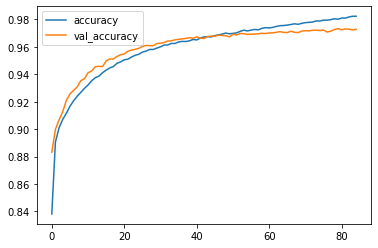

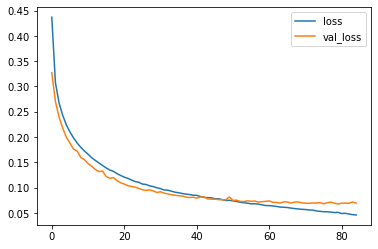

In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)

history = model.fit(train_imgs, train_df,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose = 1,
                    validation_data=(val_imgs, val_df), callbacks=[callback])

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [40]:
pred = model.evaluate(test_imgs, test_df)
print(pred)

140/140 [==============================] - 114s 808ms/step - loss: 0.0754 - accuracy: 0.9694 - precision: 0.8848 - recall: 0.8679 - auc: 0.9920
[0.07544305175542831, 0.9693676829338074, 0.8848179578781128, 0.8679245114326477, 0.9919890761375427]


In [41]:
model.save("efficient_Datapro_10_20({:.4f}_{:.4f}).h5".format(pred[0], pred[1]))